In [1]:
import pandas as pd
import numpy as np
import scipy.stats as stats
import seaborn as sns
import statsmodels.formula.api as smf
import statsmodels.api as sm

from sklearn.decomposition import PCA
from sklearn import preprocessing
from matplotlib import pyplot as plt
from datetime import datetime

from scripts.cleaning import remove_outliers

plt.style.use("Solarize_Light2")


In [2]:
%%time

df_off = pd.read_csv("data/cleaned_data.csv")
df_off.shape


CPU times: total: 359 ms
Wall time: 362 ms


(39241, 25)

<h1>Analyse des variables :</h1>


<h4>Analyse de la repartition des nutriscores :</h4>

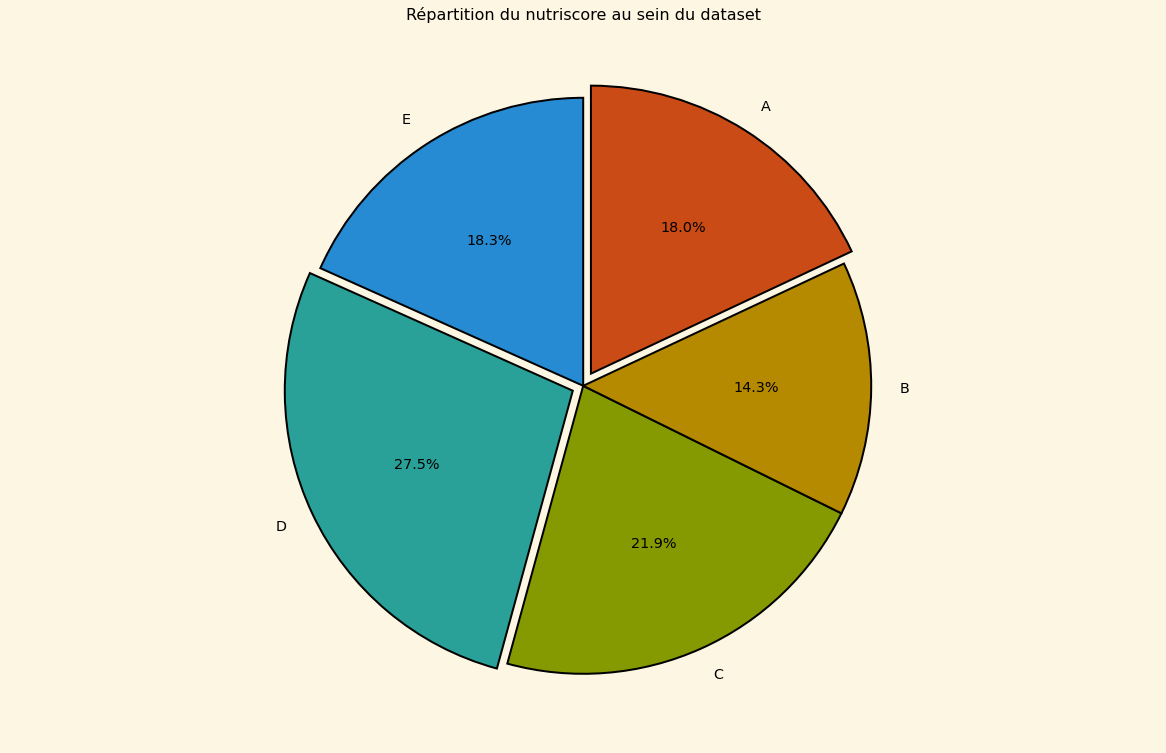

In [3]:
grades = df_off["nutrition_grade_fr"].unique()

amount = {}

for grade in grades:
        amount[grade] = df_off['nutrition_grade_fr'].value_counts()[grade]

slices = list(amount.values())
labels = [key.upper() for key in amount.keys()]

textprops = {
    "size": "x-large",
}

fig = plt.figure(figsize=(16,10))

explode = (0, 0.04, 0, 0, 0.05)
ax = fig.add_axes([0,0,1,1])
ax.axis('equal')
ax.pie(slices, labels=labels, startangle=90, explode=explode, textprops=textprops,
        autopct='%1.1f%%', wedgeprops={'linewidth': 2,'edgecolor': 'black'})

plt.title("Répartition du nutriscore au sein du dataset")
plt.savefig("repartition_nutriscore.png")
plt.show()



<h2><u>Analyse du graphe de repartition du nutriscore au sein du dataset :</u></h2>

- Les notes que l'ont peut considérer comme mauvaises (E, D et, pour certaines catégories, C) dominent largement le dataset
- A première vue, les propositions de produits de meilleur qualité selon le Nutriscore se montreront pertinentes. Il convient de faire une analyse du Nutriscore par categorie (PNNS groups 1 & 2) afin de vérifier cette hypothèse.
- Si cette observation globale se confirme parmi les grandes categories mises en places par le PNNS, l'intérêt et le potentiel de l'application seraient renforcés.

<hr>
Il convient d'analyser d'une part l'hypothèse émise plus haut et d'autre part la pertinence du Nutriscore comme outil de mesure qualitatif.
<hr>

<h2><u>Proportion de produits évalués dans le cas des variables "bio" et "huile de palme"</u></h2>

Lors du nettoyage du dataset, plusieurs labels parmi les labels "bio" les plus communs ont été sélectionnés et une tentative d'assertion de la présence d'huile de palme dans les produits a été effectuée.
<br>
Nous pouvons établir la proportion de ces évaluations respectives au sein de nos données. (<i>A noter que les produits dont la variable "Bio" a été évaluée, le label était présent et donc le produit est labellisé bio</i>)

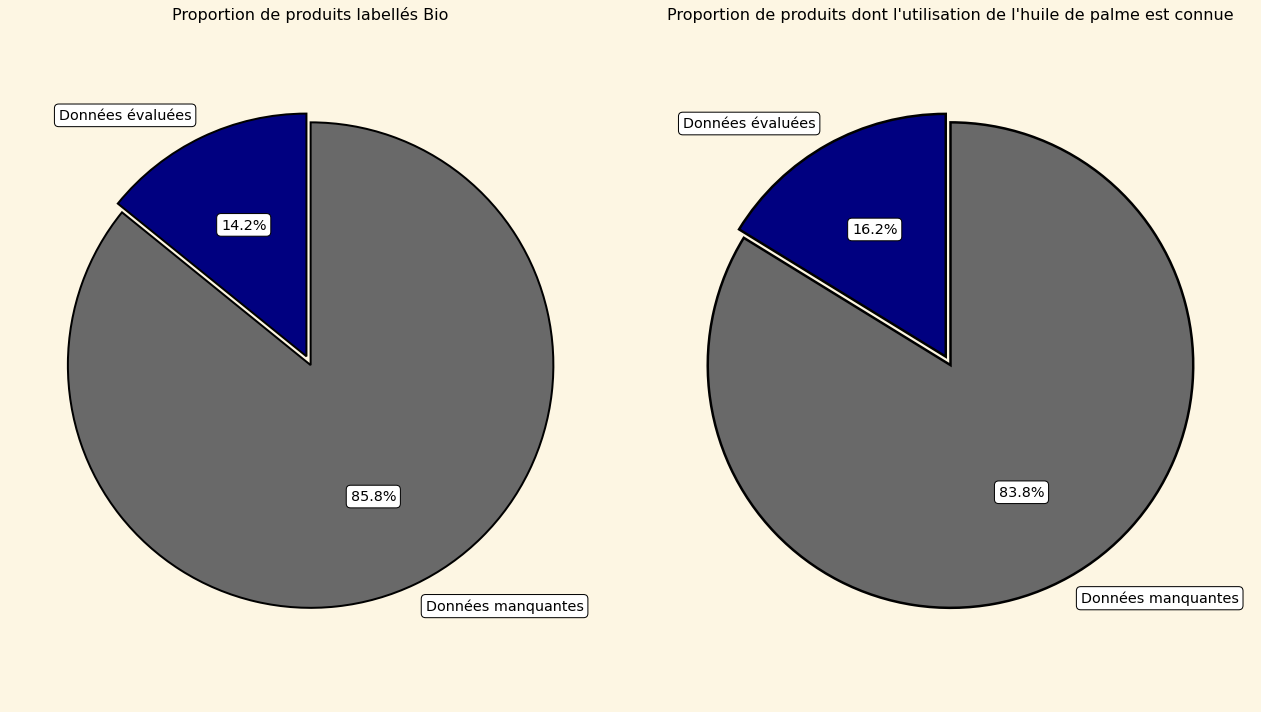

In [4]:
total_products = len(df_off)

rated_organic = df_off["organic"].notna().sum()
organic_data = [rated_organic, total_products - rated_organic]
rated_palm_oil = df_off["palm_oil"].notna().sum()
palm_oil_data = [rated_palm_oil, total_products - rated_palm_oil]

fig, (ax1, ax2) = plt.subplots(ncols=2, nrows=1, figsize=(18, 10))

labels = ["Données évaluées", "Données manquantes"]

bbox=dict(facecolor='white', edgecolor='black', boxstyle="round")

textprops = {
    "size": "x-large",
    "bbox": bbox,
    "backgroundcolor": "white",
    
}

colors = ["navy", "dimgrey"]

ax1.axis('equal')
ax2.axis('equal')

ax1.pie(
    organic_data, startangle=90, autopct='%1.1f%%',
    wedgeprops={'linewidth': 2,'edgecolor': 'black'},
    labels=labels, textprops=textprops, colors=colors,
    explode=[0.04, 0]
    )

ax2.pie(
    palm_oil_data, startangle=90, autopct='%1.1f%%',
    wedgeprops={'linewidth': 2.5,'edgecolor': 'black'},
    labels=labels, textprops=textprops, colors=colors,
    explode=[0.04, 0]
    )

ax1.set_title("Proportion de produits labellés Bio")
ax2.set_title("Proportion de produits dont l'utilisation de l'huile de palme est connue")

plt.tight_layout()
plt.show()


<h4>Dans les deux cas, le chiffre peut sembler faible mais, d'une part :</h4>

- Selon l’Observatoire de la distribution responsable (FCD) rapporte qu'en 2019 4.8% des produits trouvés en grande surface étaient d'origine "Bio". Les données évaluées ont toutes un label "Bio" listé dans le notebook de nettoyage.
- L'Observatoire des aliments affirme qu'un tiers des produits consommés contient de l'huile de palme. Dans le cas de l'indicateur calculé, il est évalué <b>si possible</b> si oui ou non l'huile de palme est utilisée. Le dataset est sans aucun doute incomplet et des données supplémentaires seraient requises.

> <h3>remarque sur PNNS group : </h3>

Le Programme National Nutrition Santé et les groupes formés par celui ci sont à plus large spectre que les categories.


In [5]:
print("Echantillon pnns_group_1", len(df_off["pnns_groups_1"].unique()))
print("Echantillon pnns_group_2", len(df_off["pnns_groups_2"].unique()))
print("Echantillon main_category_fr", len(df_off["main_category_fr"].unique()))
print("Echantillon categories_fr", len(df_off["categories_fr"].unique()))


Echantillon pnns_group_1 14
Echantillon pnns_group_2 40
Echantillon main_category_fr 837
Echantillon categories_fr 10575



- Les variables "main_category_fr" et "categories_fr" seront utiles à l'application en production. Elles permettront d'offrir plus précisément un meilleur candidat de remplacement au produit sélectionné.
- Les variables du PNNS sont plus restrictives, moins pertinentes dans un cas de comparaison, mais si elles sont assez peuplées elles peuvent permettre d'étudier les possibles corrélations entre le Nutriscore et la catégorie.

In [6]:

print("pnns_1_pop =", df_off["pnns_groups_1"].notna().sum())
print("pnns_2_pop = ", df_off["pnns_groups_2"].notna().sum())
print("Echantillon :", len(df_off))


pnns_1_pop = 39158
pnns_2_pop =  39241
Echantillon : 39241


<h2>Les deux groupes pnns peuvent utilisés avec précision.</h2>

- pnns_groups_1 : la représentation des produits est légèrement plus faible mais les critères sont plus larges, permettant un jugement d'ensemble
- pnns_groups_2 : ce groupe contient 40 groupes uniques mais couvre la totalité de notre dataset.

<h2>Représentation de la repartition des données en fonction de leur derniere data de modification :</h2>

- Les données sont au format timestamp UNIX
- Groupement par année : les timestamps sont calculés du timestamp le plus ancien au plus récent, par timestamp du premier janvier au 31 décembre de l'année

In [7]:
data_t = df_off["last_modified_t"]

oldest = datetime.fromtimestamp(data_t.min())
newest = datetime.fromtimestamp(data_t.max())

print(f"Les données s'étendent sur la periode {oldest} à {newest}")


Les données s'étendent sur la periode 2012-04-08 10:12:35 à 2017-04-21 02:53:41


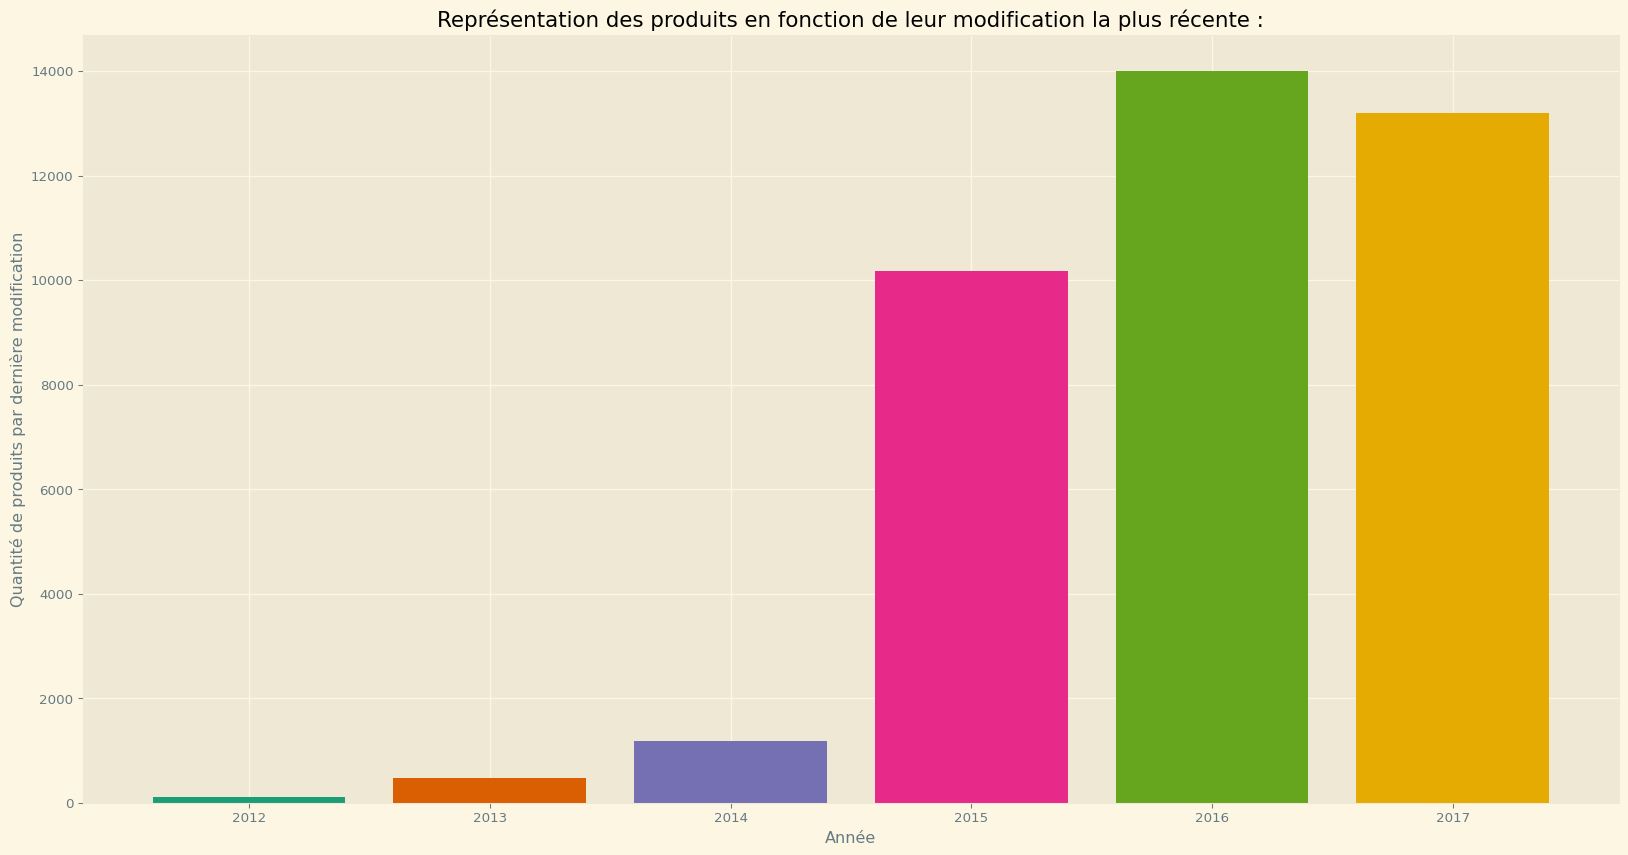

In [8]:

t_dict = {}

for year in range(2012, 2018, 1):
    jan_1=datetime(year=year, month=1, day=1).timestamp(),
    dec_31=datetime(year=year, month=12, day=31).timestamp(),
    t_dict[year] = len(data_t[(data_t > jan_1) & (data_t < dec_31)])


used_cmap = plt.get_cmap("Dark2")

fig = plt.figure(figsize=(16, 8), dpi=96)
ax = fig.add_axes([0,0,1,1])

ax.bar(t_dict.keys(), t_dict.values(), color=used_cmap.colors)

ax.set_ylabel("Quantité de produits par dernière modification")
ax.set_xlabel("Année")

title = "Représentation des produits en fonction de leur modification la plus récente :"

ax.set_title(title)
plt.show()



Par rapport à la donnée la plus récente, les autres produits ont été majoritairement mis à jour, pour la plus grande partie, 2 ans maximum avant le produit le plus récent. On peut donc considérer les données comme relativement à jour :

- Le Nutriscore a été proposé en 2014 et adopté en 2016
- Il semblerait qu'Open Food Facts ait proposé, avant son application, un système similaire <a href="https://fr.openfoodfacts.org/discover" target="blank">sur leur blog</a>
- Le Programme National Nutrition Santé a été établi en 2001 et prolongé depuis, les données peuvent donc être associées
- Le nutriscore semble être à jour dans ce dataset.

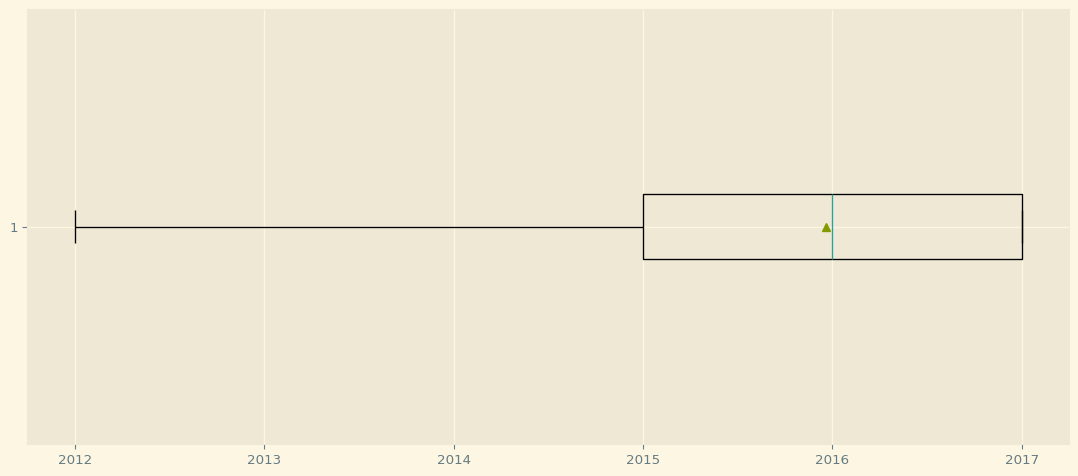

In [9]:
plt.figure(figsize=(14, 6), dpi=96)
plt.boxplot([datetime.fromtimestamp(ts).year for ts in data_t], vert=0, showmeans=True, showfliers=True)
plt.show()


Ce boxplot confirme que la très grande majorité (dès le premier quartile) des données ont été mises à jour post 2015, la notion de Nutriscore étant apparue en 2014, cela peut impliquer que, pour la très large majorité du dataset, le Nutriscore ait été ajouté après sa définition. Les valeurs anterieures à 2014 doivent avoir été calculées par le site, ou obtenues d'une autre manière (fusion des duplicatas avant publication du dataset, erreur de mise à jour de la variable "last_modified_t" (rare mais présente dans le dataset original) etc.)

<h2>Le Nutriscore peut-il être amélioré ?</h2>

- Le Nutriscore pour 100g est plus pertinent dans ce cas : les produits ne sont pas notés par 5 lettres mais par un nombre entre –15 et +40 (<a href="https://quoidansmonassiette.fr/etiquetage-nutritionnel-nutri-score-5-c-vainqueur-de-la-guerre-des-logos-nutritionnels/">source</a>) , rouge (E) est considéré avoir un score au delà de 17
- Il ne serait pas pertinent de traiter les produits indépendamment de leurs catégories : selon <a href="mangerbouger.fr">mangerbouger.fr</a> ↓
    > A retenir : Tout dépend du produit. Pour les yaourts qui peuvent être notés A, B ou C, le Nutri-Score C, est le moins bon score possible. Pour les huiles, qui peuvent être notées C, D ou E, le Nutri-Score C, est le meilleur score possible.

- Il convient d'étudier la relation entre le nutriscore et les composants nocifs en grande quantité (graisses et sucres) pour étudier la pertinence de cette variable.

In [10]:
pnns_1 = list(df_off["pnns_groups_1"].unique())

for group in pnns_1:
    print(group, "- nombre de lignes : ", len(df_off[df_off["pnns_groups_1"] == group]))


Beverages - nombre de lignes :  3885
Sugary snacks - nombre de lignes :  6260
Salty snacks - nombre de lignes :  1607
Fruits and vegetables - nombre de lignes :  2479
unknown - nombre de lignes :  3854
Fat and sauces - nombre de lignes :  2520
Cereals and potatoes - nombre de lignes :  4494
Composite foods - nombre de lignes :  4559
fruits-and-vegetables - nombre de lignes :  383
Milk and dairy products - nombre de lignes :  4543
nan - nombre de lignes :  0
Fish Meat Eggs - nombre de lignes :  4243
sugary-snacks - nombre de lignes :  330
cereals-and-potatoes - nombre de lignes :  1


<h4>Choix de 4 valeurs :</h4>

- Salty snacks
- Composite foods
- Sugary snacks (capitalized)
- Beverages


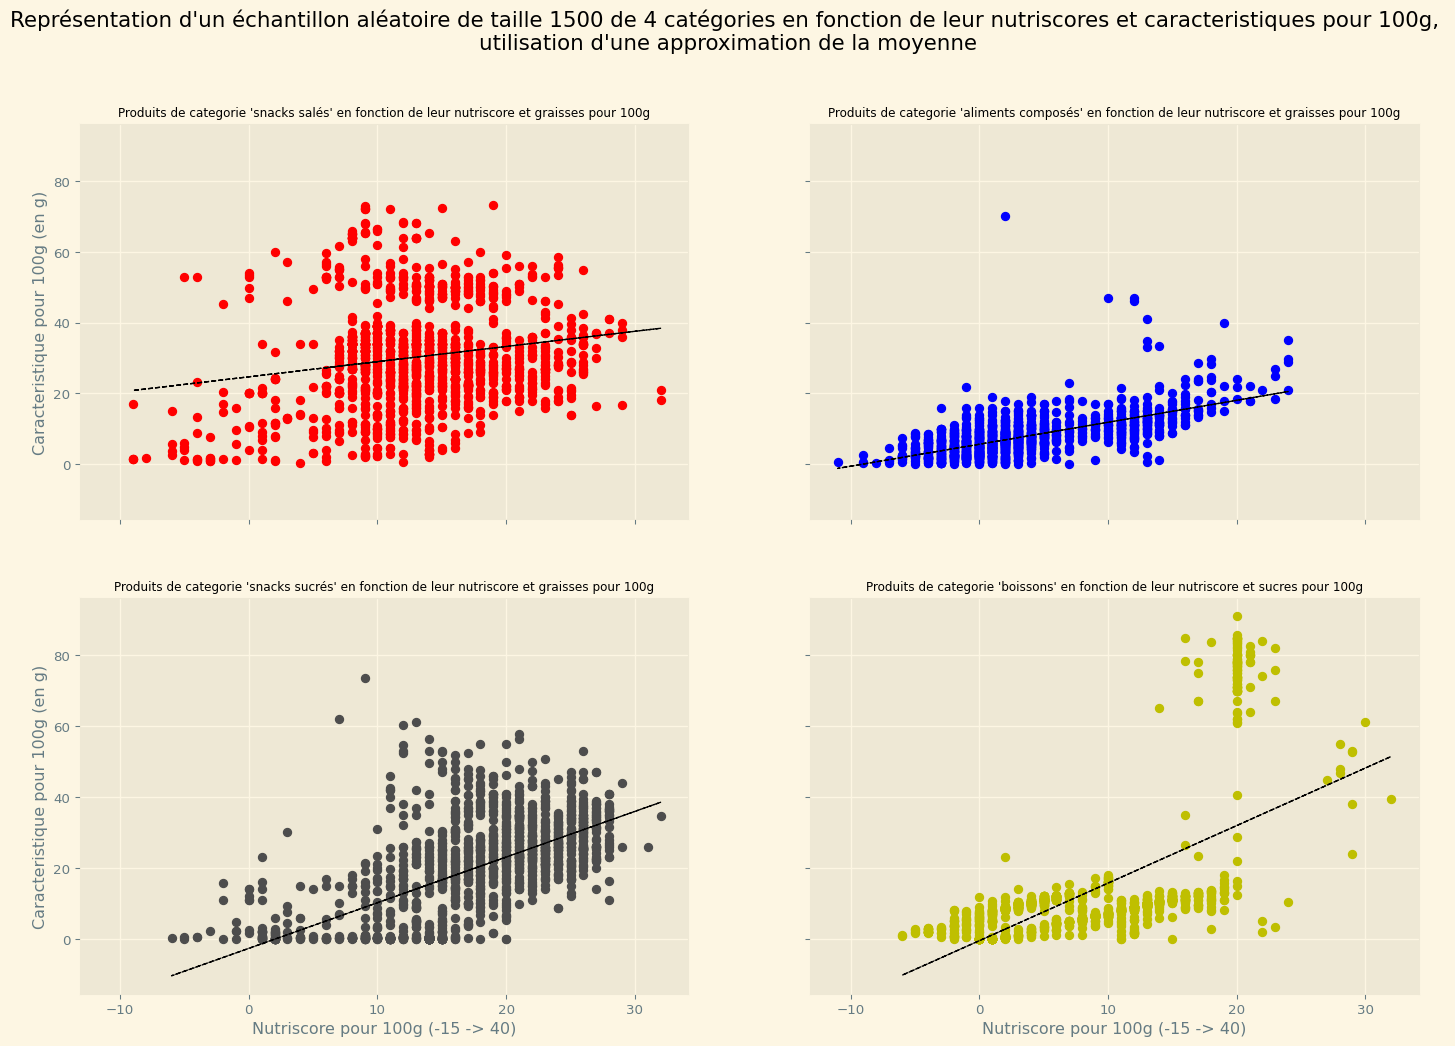

In [11]:
fig, ((ax1, ax2), (ax3, ax4)) = plt.subplots(
    ncols=2,
    nrows=2,
    figsize=(18, 12),
    dpi=96,
    sharex=True,
    sharey=True
)


salty_data = df_off[df_off["pnns_groups_1"] == "Salty snacks"][["nutrition-score-fr_100g", "fat_100g"]]
salty_data = salty_data[salty_data["fat_100g"].notna()]
salty_data = salty_data.sample(n=1500)

composite_data = df_off[df_off["pnns_groups_1"] == "Composite foods"][["nutrition-score-fr_100g", "fat_100g"]]
composite_data = composite_data[composite_data["fat_100g"].notna()]
composite_data = composite_data.sample(n=1500)

sugary_data = df_off[df_off["pnns_groups_1"] == "Sugary snacks"][["nutrition-score-fr_100g", "fat_100g"]]
sugary_data = sugary_data[sugary_data["fat_100g"].notna()]
sugary_data = sugary_data.sample(n=1500)

beverages_data = df_off[df_off["pnns_groups_1"] == "Beverages"][["nutrition-score-fr_100g", "sugars_100g"]]
beverages_data = beverages_data[beverages_data["sugars_100g"].notna()]
beverages_data = beverages_data.sample(n=1500)


ax1.scatter(salty_data["nutrition-score-fr_100g"], salty_data["fat_100g"], color="r")
z = np.polyfit(x=(salty_data["nutrition-score-fr_100g"]), y=salty_data["fat_100g"], deg=1)
p = np.poly1d(z)
ax1.plot((salty_data["nutrition-score-fr_100g"]), p(list(salty_data["nutrition-score-fr_100g"])), "k--", linewidth=1.0)

ax2.scatter(composite_data["nutrition-score-fr_100g"], composite_data["fat_100g"], color="b")
z2 = np.polyfit(x=(composite_data["nutrition-score-fr_100g"]), y=composite_data["fat_100g"], deg=1)
p2 = np.poly1d(z2)
ax2.plot((composite_data["nutrition-score-fr_100g"]), p2(list(composite_data["nutrition-score-fr_100g"])), "k--", linewidth=1.0)

ax3.scatter(sugary_data["nutrition-score-fr_100g"], sugary_data["fat_100g"], color="0.3")
z3 = np.polyfit(x=(sugary_data["nutrition-score-fr_100g"]), y=sugary_data["fat_100g"], deg=1)
p3 = np.poly1d(z3)
ax3.plot((sugary_data["nutrition-score-fr_100g"]), p3(list(sugary_data["nutrition-score-fr_100g"])), "k--", linewidth=1.0)

ax4.scatter(beverages_data["nutrition-score-fr_100g"], beverages_data["sugars_100g"], color="y")
z4 = np.polyfit(x=(beverages_data["nutrition-score-fr_100g"]), y=beverages_data["sugars_100g"], deg=1)
p4 = np.poly1d(z4)
ax4.plot((beverages_data["nutrition-score-fr_100g"]), p4(list(beverages_data["nutrition-score-fr_100g"])), "k--", linewidth=1.0)

# - Salty snacks=ax1 Composite foods=ax2 Sugary snacks=ax3 Beverages=ax4

###
# Titles and labels
ax1.set_title("Produits de categorie 'snacks salés' en fonction de leur nutriscore et graisses pour 100g", size=9)
ax2.set_title("Produits de categorie 'aliments composés' en fonction de leur nutriscore et graisses pour 100g", size=9)
ax3.set_title("Produits de categorie 'snacks sucrés' en fonction de leur nutriscore et graisses pour 100g", size=9)
ax4.set_title("Produits de categorie 'boissons' en fonction de leur nutriscore et sucres pour 100g", size=9)
figure_title = "Représentation d'un échantillon aléatoire de taille 1500 de\
 4 catégories en fonction de leur nutriscores et caracteristiques pour 100g\
, \nutilisation d'une approximation de la moyenne"

fig.suptitle(figure_title, fontsize=16)
ax3.set_xlabel("Nutriscore pour 100g (-15 -> 40)")
ax4.set_xlabel("Nutriscore pour 100g (-15 -> 40)")
ax1.set_ylabel("Caracteristique pour 100g (en g)")
ax3.set_ylabel("Caracteristique pour 100g (en g)")
#
###

plt.show()


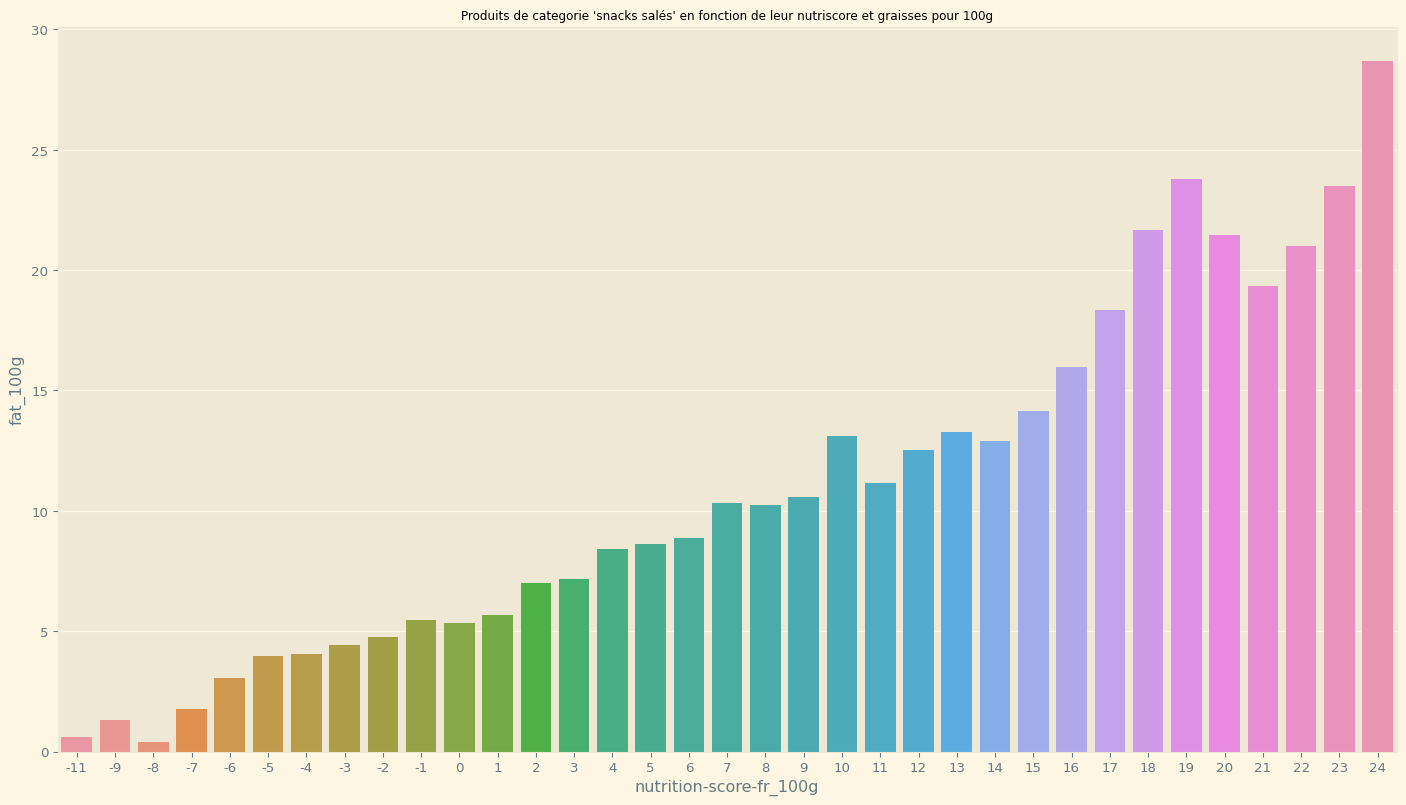

In [12]:
fig, ax = plt.subplots(
    ncols=1,
    nrows=1,
    figsize=(18, 10),
    dpi=96,
    sharex=True,
    sharey=True
)

ax = sns.barplot(x="nutrition-score-fr_100g", y="fat_100g", data=composite_data, ci=None)

ax.set_title("Produits de categorie 'snacks salés' en fonction de leur nutriscore et graisses pour 100g", size=9)

plt.show()


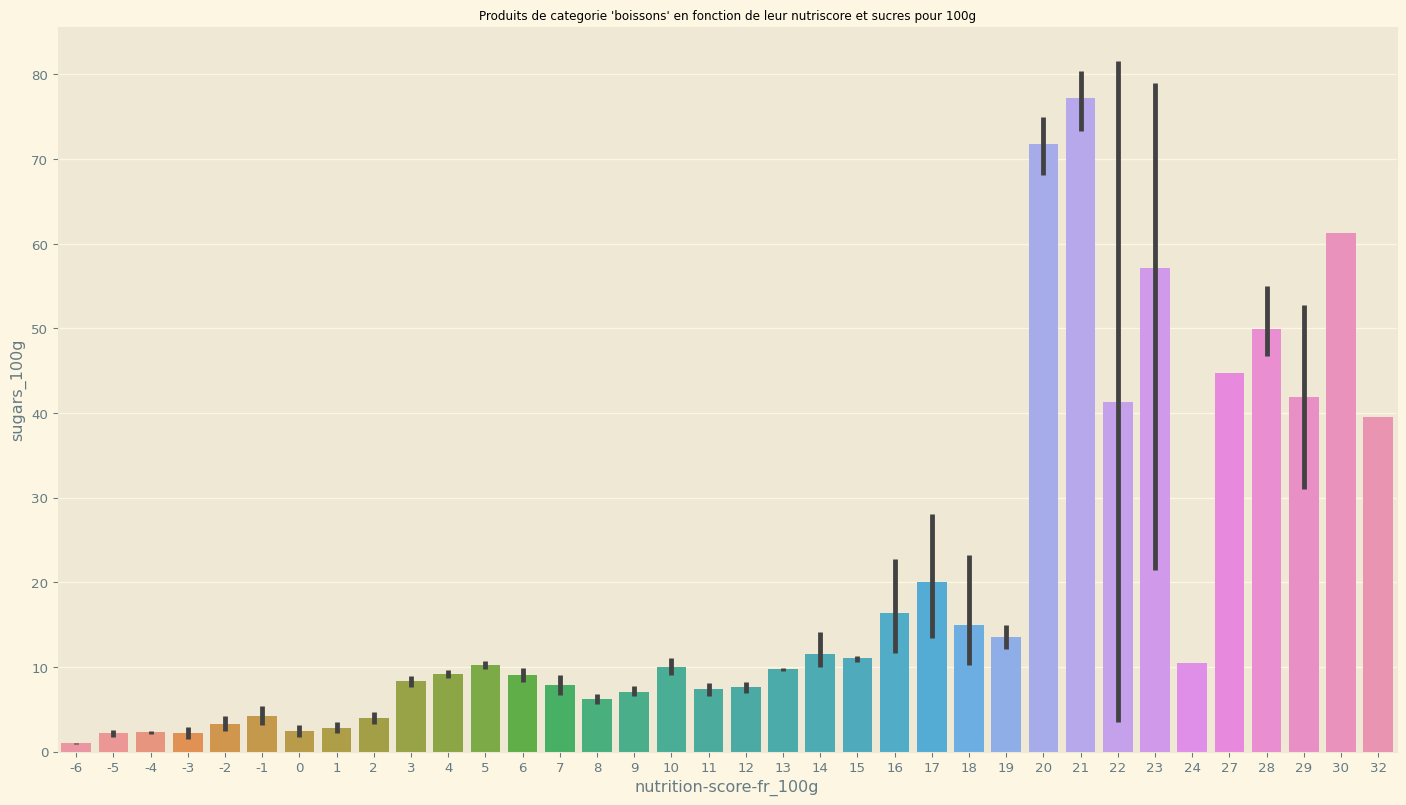

In [13]:
fig, ax = plt.subplots(
    ncols=1,
    nrows=1,
    figsize=(18, 10),
    dpi=96,
    sharex=True,
    sharey=True
)

ax = sns.barplot(x="nutrition-score-fr_100g", y="sugars_100g", data=beverages_data)

ax.set_title("Produits de categorie 'boissons' en fonction de leur nutriscore et sucres pour 100g", size=9)

plt.show()


L'analyse de ces deux variables (Nutriscore pour 100g et caracteristiques que l'ont peut qualifier de mauvaises pour la santé en forte quantité) révèlent une corrélation entre le Nutriscore et ces features.
On compte néanmoins des valeurs abérrantes qui peuvent s'expliquer par la présence d'autres caractéristiques influençant le Nutriscore. La tendance montre que le Nutriscore est négativement affecté par des features comme la graisse et le sucre.

Le Nutriscore est également impacté par des features considérées comme positives telles que les fruits & legumes, les fibres et la teneur en protéine : <a href="https://www.health.belgium.be/sites/default/files/uploads/fields/fpshealth_theme_file/2019_faq_fr_v35_ph.pdf">source</a>. Cela explique la présence de nombreux outliers : seul un facteur par produit a été exploré, hors le Nutriscore en prend au moins 5 autres en compte.

Le calcul d'une autre métrique ou le recalcul du nutriscore ne semble pas nécessaire.


<h2>Deux questions peuvent se poser :</h2>

- Les produits bios sont ils plus sains ?
- Ceux contenant de l'huile de palme sont ils moins sains ?

In [14]:
data_org_pal = df_off[["nutrition-score-fr_100g", "organic", "palm_oil"]]
data_org_pal.dropna(subset=["nutrition-score-fr_100g"])
data_org_pal = data_org_pal.fillna(False)


<h2>Etude de la possible implication de l'huile de palme et du caractère 'bio' d'un produit sur son Nutriscore</h2>

- <b>A noter :</b>
    - Les données concernant l'huile de palme ont été récupérées en cherchant sa présence dans le dataset original. Il est entèrement possible et fort probable qu'une partie des produits ait échappé à ce scan.
    - Le caractère bio d'un produit a été déterminé par ses labels, parmi la liste labels bio les plus populaires selon Open Food Facts. Il est possible que certains produits soient qualifiés de bio mais n'aient pas été labellisés comme tels
    - Nous considérerons les données manquantes comme fausses. La pertinence dans le cas du bio est probablement forte (c.f. représentation de la quantité de produits bios dans le dataset), mais l'huile de palme est probablement sous représentée

<hr>
- On émmet donc les hypotèses nulles :

    - Hb0 : On suppose qu'en moyenne les produits bio ont le même Nutriscore pour 100g que les produits non-bio et qu'il n'y a pas de corrélation positive entre le Nutriscore et le caractère bio d'un produit.
    - Hp0 : On suppoer qu'en moyenne les produits contenant de l'huile de palmes ont le même Nutriscore pour 100g que les produits qui n'en contiennent pas (selon non informations). Il n'y a pas de corrélation négative entre l'huile de palme et le Nutriscore pour 100g d'un produit.

<hr>

<h4>Interets pour l'application :</h4>

- L'application pourrait gagner en éfficacité si elle cherchait en priorité des remplacements dans des sous ensembles plus reduit de produits (ici : Bio et sans Huile de palme) : cela permettrait un gain de temps dans la recherche puisqu'un sous ensemble pourrait être évalué en priorité.
- Ces variables resteraient des variables métier importantes peu importe le reste du test : on suppose que certain utilisateurs pourraient chercher des produits répondant spécifiquement à des caractertiques comme celles ci.
  

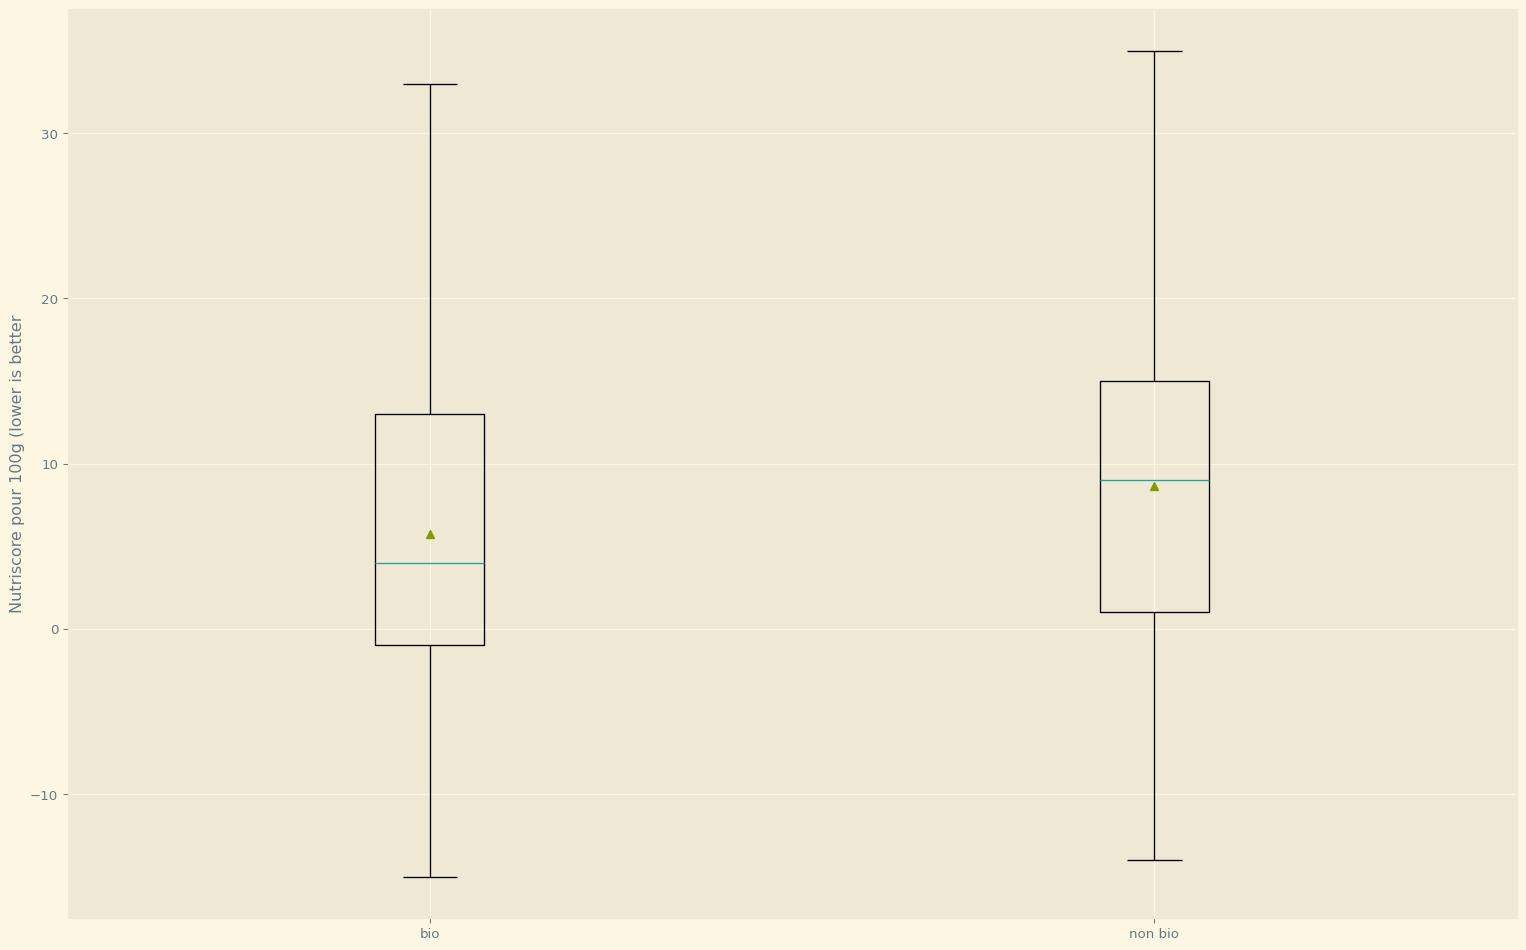

In [15]:
fig, ax1 = plt.subplots(
    ncols=1,
    nrows=1,
    figsize=(16, 10),
    dpi=96,
    sharex=True,
    sharey=True
)

data_org = data_org_pal[data_org_pal["organic"]][["nutrition-score-fr_100g", "organic"]]
data_org_t = data_org_pal[data_org_pal["organic"] == True][["nutrition-score-fr_100g"]]
data_org_f = data_org_pal[data_org_pal["organic"] == False][["nutrition-score-fr_100g"]]
data_org_list = [data_org_t["nutrition-score-fr_100g"], data_org_f["nutrition-score-fr_100g"]]

ax1.boxplot(data_org_list, showfliers=True, showbox=True, showmeans=True, labels=["bio", "non bio"])
ax1.set_ylabel("Nutriscore pour 100g (lower is better")

data_palm_pos = data_org_pal[data_org_pal["palm_oil"] == True][["nutrition-score-fr_100g", "palm_oil"]]
data_palm_undetected = data_org_pal[data_org_pal["palm_oil"].isna()][["nutrition-score-fr_100g", "palm_oil"]]

plt.tight_layout()
plt.show()


In [16]:
hashes = "\n###############################"
print("General : \n", data_org_pal[["organic", "nutrition-score-fr_100g"]].describe(), hashes)
print("Bio : \n", data_org_pal[data_org_pal["organic"] == True].describe(), hashes)
print("Non Bio : \n", data_org_pal[data_org_pal["organic"] == False].describe(), hashes)


General : 
        nutrition-score-fr_100g
count             39241.000000
mean                  8.227950
std                   8.971378
min                 -15.000000
25%                   1.000000
50%                   8.000000
75%                  15.000000
max                  35.000000 
###############################
Bio : 
        nutrition-score-fr_100g
count              5559.000000
mean                  5.714157
std                   8.948202
min                 -15.000000
25%                  -1.000000
50%                   4.000000
75%                  13.000000
max                  33.000000 
###############################
Non Bio : 
        nutrition-score-fr_100g
count             33682.000000
mean                  8.642836
std                   8.907382
min                 -14.000000
25%                   1.000000
50%                   9.000000
75%                  15.000000
max                  35.000000 
###############################


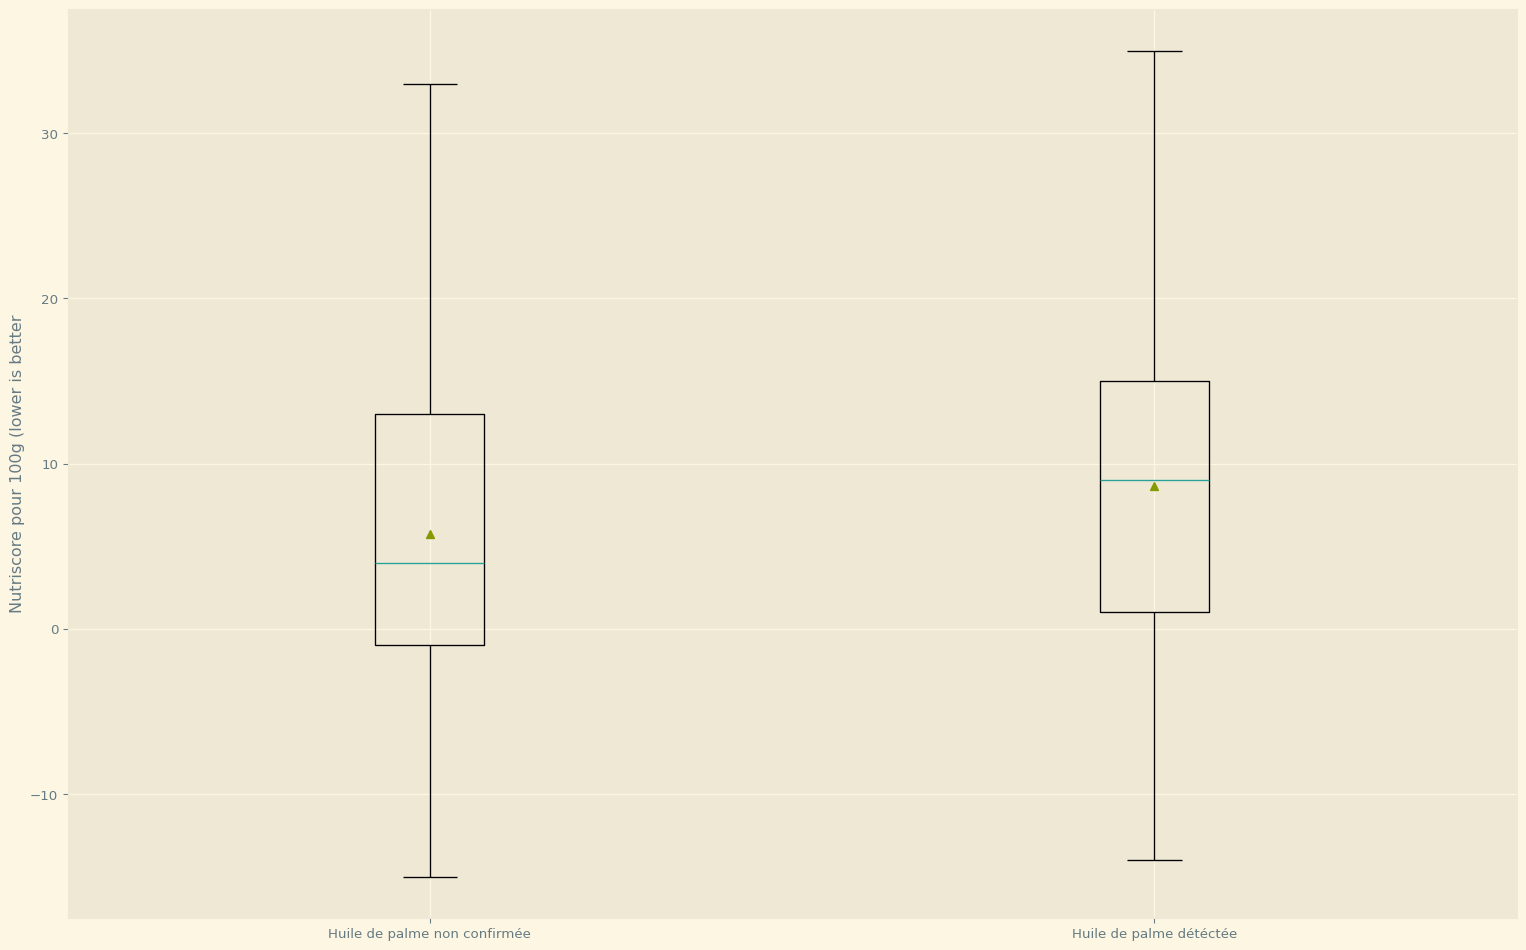

In [17]:
fig, ax1 = plt.subplots(
    ncols=1,
    nrows=1,
    figsize=(16, 10),
    dpi=96,
    sharex=True,
    sharey=True
)

data_palm = data_org_pal[data_org_pal["palm_oil"]][["nutrition-score-fr_100g", "palm_oil"]]
data_palm_t = data_org_pal[data_org_pal["palm_oil"] == True][["nutrition-score-fr_100g"]]
data_palm_f = data_org_pal[data_org_pal["palm_oil"] == False][["nutrition-score-fr_100g"]]
data_palm_list = [data_palm_f["nutrition-score-fr_100g"], data_palm_t["nutrition-score-fr_100g"]]

ax1.boxplot(data_org_list, showfliers=True, showbox=True, showmeans=True, labels=["Huile de palme non confirmée", "Huile de palme détéctée"])
ax1.set_ylabel("Nutriscore pour 100g (lower is better")

data_palm_pos = data_org_pal[data_org_pal["palm_oil"] == True][["nutrition-score-fr_100g", "palm_oil"]]
data_palm_undetected = data_org_pal[data_org_pal["palm_oil"].isna()][["nutrition-score-fr_100g", "palm_oil"]]

plt.tight_layout()
plt.show()


In [18]:
hashes = "\n###############################"
print("General : \n", data_org_pal[["palm_oil", "nutrition-score-fr_100g"]].describe(), hashes)
print("Avec huile de palme : \n", data_org_pal[data_org_pal["palm_oil"] == True].describe(), hashes)
print("Sans huile de palme : \n", data_org_pal[data_org_pal["palm_oil"] == False].describe(), hashes)


General : 
        nutrition-score-fr_100g
count             39241.000000
mean                  8.227950
std                   8.971378
min                 -15.000000
25%                   1.000000
50%                   8.000000
75%                  15.000000
max                  35.000000 
###############################
Avec huile de palme : 
        nutrition-score-fr_100g
count              6363.000000
mean                 13.151972
std                   8.206737
min                 -11.000000
25%                   7.000000
50%                  14.000000
75%                  19.000000
max                  35.000000 
###############################
Sans huile de palme : 
        nutrition-score-fr_100g
count             32878.000000
mean                  7.274986
std                   8.799381
min                 -15.000000
25%                   0.000000
50%                   6.000000
75%                  14.000000
max                  35.000000 
###############################


<h4> Analyse des variances (ANOVAs) et hypthèses alternatives </h4>

- On définit alpha = 5%
- Hb1 : Les produits bios ont en moyenne un meilleur nutriscore que les produits non bio, il existe une corrélation positive entre le caractère bio d'un produit et son Nutriscore.
- Hp1 : Les produits contenant de l'huile de palme on en moyenne un Nutriscore pour 100g plus mauvais que les autres produits. Il éxiste une corrélation négative entre la présence d'huile de palme et le nutriscore d'un produit

<hr>
-> Pour effectuer une ANOVA, trois conditions doivent être vérifiées :

- 1. La normalité des résidus (test de shapiro sur les resultats)
- 2. Indépendance des échantillons (supposées dans ce cas)
- 3. Une variance homogène entre les échantillons (on utilisera le test de Bartlett)


In [19]:
alpha = 0.05
α = 0.05  # Double definition for unicode possible errors

<h4>A noter : </h4>

- L'utilisation de R dans la librairie statsmodels force à renommer les colonnes contenant des dashes (-)
- R et statsmodels ne permettent pas d'analyser des données booléennes : nous remplacement : 0 = False, True = 1

In [20]:
bartlett_test_org = stats.bartlett(data_org_t["nutrition-score-fr_100g"], data_org_f["nutrition-score-fr_100g"])

print(bartlett_test_org)
print(bartlett_test_org.pvalue > α)


BartlettResult(statistic=0.19989226055343223, pvalue=0.6548078242471653)
True


La valeur p du test de Bartlett étant supérieure à alpha (5%), on ne peut pas rejeter l'hypothèse nulle telle supposant que les variances des échantillons sont homogènes.
<br>
On peut donc procéder à une ANOVA

In [21]:
renamed_org = data_org.rename(columns={"nutrition-score-fr_100g": "nsfr"})
renamed_org.dropna(inplace=True)

model_org = smf.ols('nsfr ~ organic', data=renamed_org).fit()

shapiro_test_org = stats.shapiro(model_org.resid)
print(shapiro_test_org)
print(shapiro_test_org.pvalue > α)


ShapiroResult(statistic=0.9529296159744263, pvalue=5.2910703857454313e-39)
False


c:\Users\Pierre Sempere\Documents\github\ds_project_3\env\lib\site-packages\scipy\stats\_morestats.py:1761: UserWarning: p-value may not be accurate for N > 5000.
  warnings.warn("p-value may not be accurate for N > 5000.")


La valeur p du test de Shapiro-Wilks est inferieure à alpha (5%). <b>On ne peut pas accepter H0</b> telle que H0 = Les residus de l'ANOVA sont gaussiens.
Les resultats de l'ANOVA ne seront donc pas valides

In [22]:
anova_table_org = sm.stats.anova_lm(model_org, typ=2)
anova_table_org


,sum_sq,df,F,PR(>F)
organic,181510.204173,1.0,2266.477318,0.0
Residual,445030.795827,5557.0,NaN,NaN


- Comme décrit plus haut, la condition de l'ANOVA supposant la normalité des résidus étant violée. <b>On ne peut pas interpreter avec confiance les resultats de l'ANOVA et rejetter l'hypothèse nulle Hb0 émise plus haut.</b>

- Nous ne pourrons donc pas optimiser l'application (sur la base de ces données seules) en cherchant un substitut en priorité dans la sous catégorie "Bio"

<hr>

In [23]:
bartlett_test_palm = stats.bartlett(data_palm_t["nutrition-score-fr_100g"], data_palm_f["nutrition-score-fr_100g"])

print(bartlett_test_palm)
print(bartlett_test_palm.pvalue > α)


BartlettResult(statistic=50.21654549384932, pvalue=1.3768203634323602e-12)
False


- La valeur p du test de Bartlett étant inférieure à alpha (5%), on peut rejetter l'hypothèse nulle telle supposant que les variances des échantillons sont homogènes. On accepte l'hypothèse alternative H1 : Les variances inter échantillons ne sont pas homogènes.
<br>
- On ne peut donc pas procéder à une ANOVA
- L'application ne pourra pas être optimisée en cherchant en priorité les produits sans huile de palme, sur la base de ces données.

<hr>

In [24]:
renamed_palm = data_palm.rename(columns={"nutrition-score-fr_100g": "nsfr"})
renamed_palm.dropna(inplace=True)

model_palm = smf.ols('nsfr ~ palm_oil', data=renamed_palm).fit()

shapiro_test_palm = stats.shapiro(model_palm.resid)
print(shapiro_test_palm)
print(shapiro_test_palm.pvalue > α)


ShapiroResult(statistic=0.9746857285499573, pvalue=3.957384310521376e-32)
False


c:\Users\Pierre Sempere\Documents\github\ds_project_3\env\lib\site-packages\scipy\stats\_morestats.py:1761: UserWarning: p-value may not be accurate for N > 5000.
  warnings.warn("p-value may not be accurate for N > 5000.")


In [25]:
anova_table_palm = sm.stats.anova_lm(model_org, typ=2)
anova_table_palm


,sum_sq,df,F,PR(>F)
organic,181510.204173,1.0,2266.477318,0.0
Residual,445030.795827,5557.0,NaN,NaN


<h3>Les variables Bio et Huile de Palme :</h3>

Même si elles ne pourront pas être utilisées dans le calcul d'un substitut, ce sont des variables qui sont importantes à certaines catégories d'utilisateurs : certains utilisateurs chercheront des produits issus d'un processus dit Bio ou ne contenant pas d'huile de palme. Cela peut constituer un plus pour l'application et ces variables seront affichées pour l'utilisateur, et pourront être utilisées pour filtrer spécifiquement des produits sur la base des préférences personnelles des utilisateurs.
<hr>
<hr>

<h2>Verification de la relation categorie/nutriscore</h2>

- Extraction des 10 categories PNNS (group 2) les plus peuplées
- Représentation de ces catégories en fonction de leur nutriscore pour 100g
- Analyse de la variance (ANOVA)

L'application pourrait possiblement gagner en éfficacité mais perdre en présicision lors des recommandations (l'utilisateur souhaiterait avoir un produit plus sain de la même catégorie en géneral)

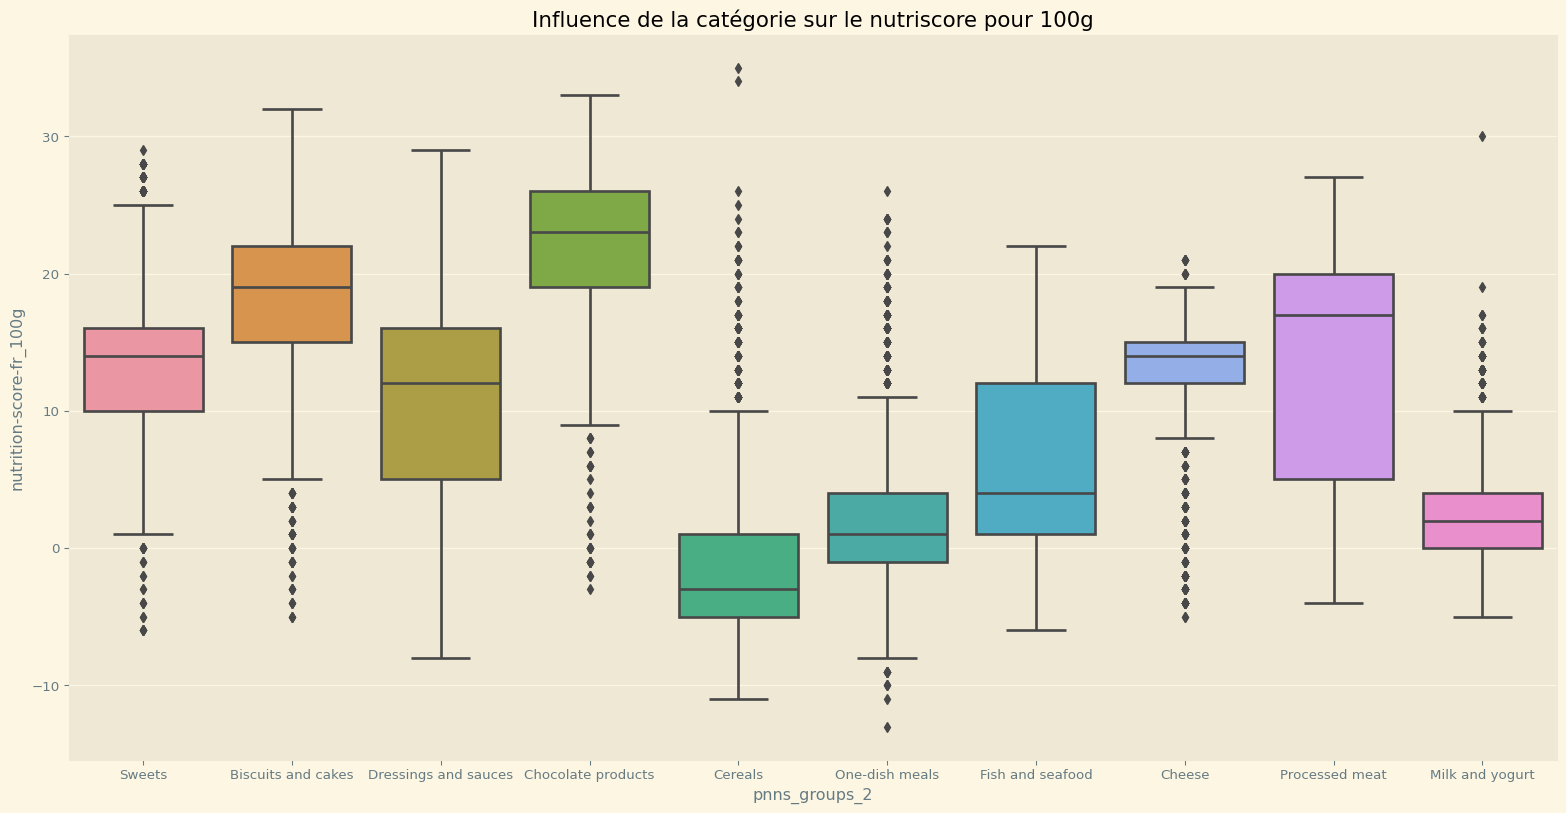

In [26]:
pnns_2_groups = list(df_off["pnns_groups_2"].unique())
pnns_2_groups.remove("unknown")
pnns_2 = []

for group in pnns_2_groups:
    pnns_2.append((group, len(df_off[df_off["pnns_groups_2"] == group])))

pnns_2.sort(key=lambda tup: tup[1], reverse=True)
top_10_by_pop = pnns_2[:10]
top_10_by_pop = [group[0] for group in top_10_by_pop]
pnns_2_df = df_off[df_off["pnns_groups_2"].isin(top_10_by_pop)][["pnns_groups_2", "nutrition-score-fr_100g"]]

fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(20, 10), dpi=96)
ax = sns.boxplot(x="pnns_groups_2", y="nutrition-score-fr_100g", data=pnns_2_df)
ax.set_title("Influence de la catégorie sur le nutriscore pour 100g")
plt.show()


<h2>Interpretation</h2>

- A première vue, la catégorie semble avoir un fort impact sur le nutriscore pour 100g.
- Les graphiques ci dessus <b>montrent une forte quantité de valeurs aberrantes</b>. On utilisera la methode interquartile pour les écarter l'évaluation de l'ANOVA
- Nous pouvons donc dresser l'hypothese nulle H0 telle que H0 = Le nutriscore d'un produit n'est pas affecté par la catégorie étudiée.
- Nous pouvons utiliser l'ANOVA pour tenter de refuter l'hypothèse nulle H0


In [27]:
pnns_2_df
pnns_2_cleaned_df = remove_outliers(
    column_eval="nutrition-score-fr_100g",
    col_subset="pnns_groups_2",
    value_list=top_10_by_pop,
    df=pnns_2_df
    )


Vérification du nettoyage en répetant les boxplots précedents avec les nouveaux parametres.

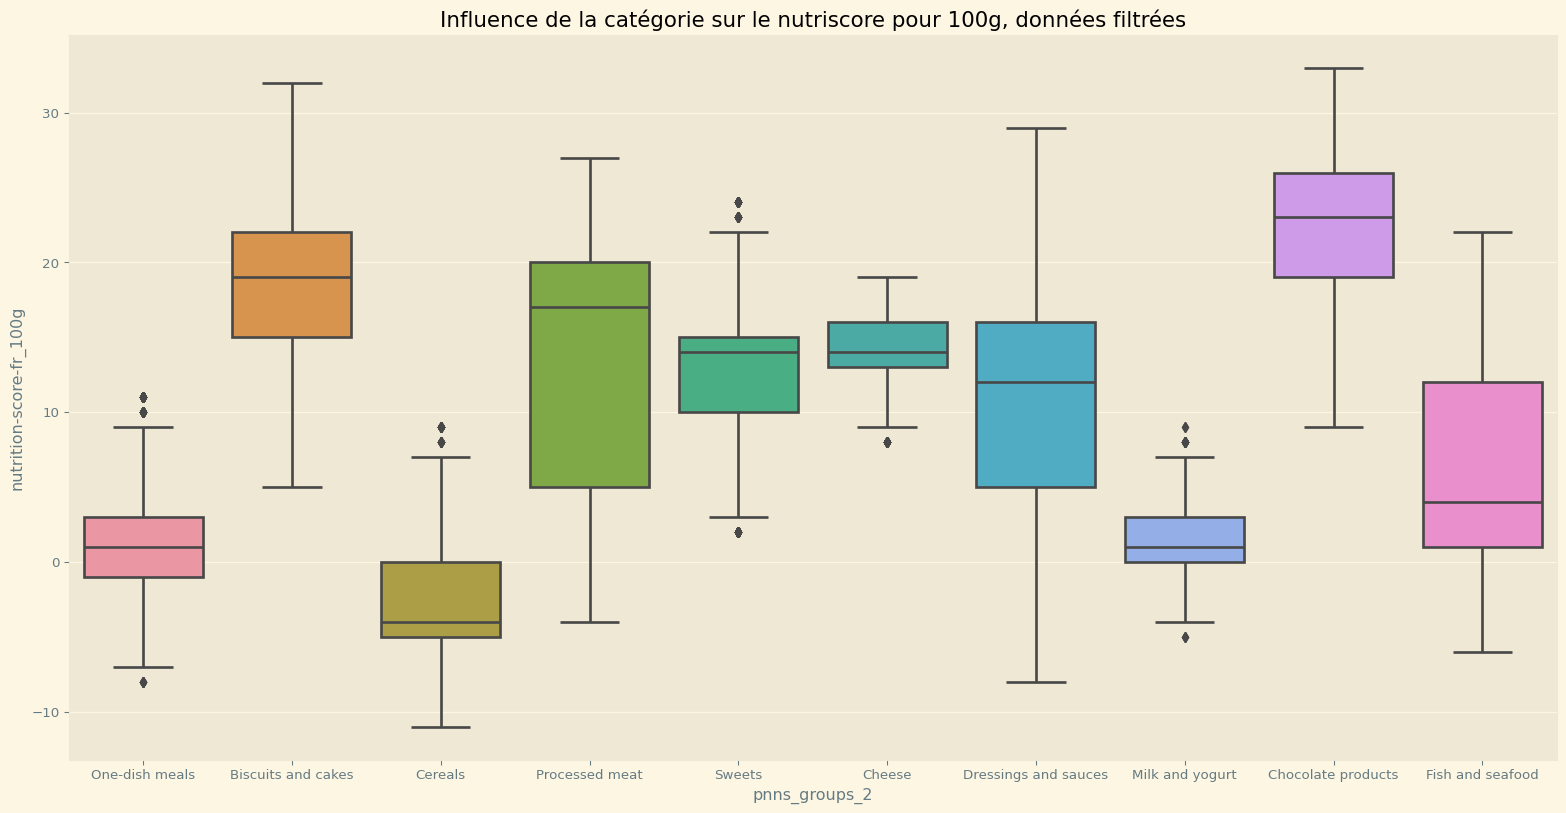

In [28]:
fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(20, 10), dpi=96)
ax = sns.boxplot(x="pnns_groups_2", y="nutrition-score-fr_100g", data=pnns_2_cleaned_df)

ax.set_title("Influence de la catégorie sur le nutriscore pour 100g, données filtrées")
plt.show()


<h4>Après l'élimination des valeurs aberrantes :</h4>

- On note un très faible taux de valeurs extrèmes, faisant partie de la valeur interquartile.
- On préfère donc utiliser ce DataFrame au précedent, contenant trop de valeurs abérrantes.
- On éfféctue en amont les tests nécessaires à l'ANOVA :

In [29]:
# Scipy doesnt understand list comprehension or list of list as arg
data_pnns = [pnns_2_cleaned_df[pnns_2_cleaned_df["pnns_groups_2"] == value]["nutrition-score-fr_100g"].tolist() for value in top_10_by_pop]

bartlett_test_cat = stats.bartlett(data_pnns[0], data_pnns[1], data_pnns[2], data_pnns[3], data_pnns[4], data_pnns[5], data_pnns[6], data_pnns[8], data_pnns[9])
print(bartlett_test_cat)
print(bartlett_test_cat.pvalue > alpha)


BartlettResult(statistic=3702.430749532815, pvalue=0.0)
False


La valeur p du test de Bartlett étant inférieure à alpha (5%), on doit rejeter l'hypothèse nulle telle supposant que les variances des échantillons sont homogènes. On accepte l'hypothèse alternative H1 : Les variances inter échantillons ne sont pas homogènes.
<br>
On ne peut donc pas procéder à une ANOVA

> La methode est implementée si dessous. Si les conditions préalable à une ANOVA sont respectées, le code ci dessous permettra d'utiliser les résultats.

In [30]:
# Renaming columns, the R like synthax doesnt seem to like the dashes
pnns_2_cleaned_df["nutrition-score-fr_100g"] = pd.to_numeric(pnns_2_cleaned_df["nutrition-score-fr_100g"])
renamed = pnns_2_cleaned_df.rename(columns={"pnns_groups_2": "PnnsGrp", "nutrition-score-fr_100g": "nsfr"})
renamed.dropna(inplace=True)

model = smf.ols('nsfr ~ PnnsGrp', data=renamed).fit()
shapiro_test_cat = stats.shapiro(model.resid)
print(shapiro_test_cat)
print(shapiro_test_cat.pvalue > alpha)


ShapiroResult(statistic=0.991374671459198, pvalue=2.4143932506231968e-32)
False


c:\Users\Pierre Sempere\Documents\github\ds_project_3\env\lib\site-packages\scipy\stats\_morestats.py:1761: UserWarning: p-value may not be accurate for N > 5000.
  warnings.warn("p-value may not be accurate for N > 5000.")


La valeur p du test de Shapiro-Wilks est inferieure à alpha (5%). On ne peut pas accepter H0 telle que H0 = Les residus de l'ANOVA sont gaussiens.
Les resultats de l'ANOVA ne seront donc pas valides

In [31]:
anova_table = sm.stats.anova_lm(model, typ=2)
anova_table


,sum_sq,df,F,PR(>F)
PnnsGrp,1.205499e+06,9.0,5532.939536,0.0
Residual,4.739060e+05,19576.0,NaN,NaN


<h2>Impossibilité d'interprétation de l'ANOVA sur les catégories</h2>

- Le test de Bartlett sur les données utilisées pour mettre en place une ANOVA a montré que les variances n'étaient pas homogènes
- Le test de Shapiro-Wilk éfféctué sur les résidus de l'ANOVA a montré que ces résidus ne ont pas normalement distribués

-> Ce test n'avait néanmoins que peu d'importance pour l'application : l'intéret se trouve dans le remplacement d'un produit (de la meme categorie).
<hr>

<h2>Analyses des composants principaux du Dataset</h2>

- On cherche à déterminer si une réduction de dimension peut être envisagée
- On prendra en compte les valeurs pour 100g, en gardant à l'esprit que les variables doivent être tout de même explicites pour que l'utilisateur final puisse les comprendre
- On cherche à déterminer les contributions des différentes variables sur le dataset.

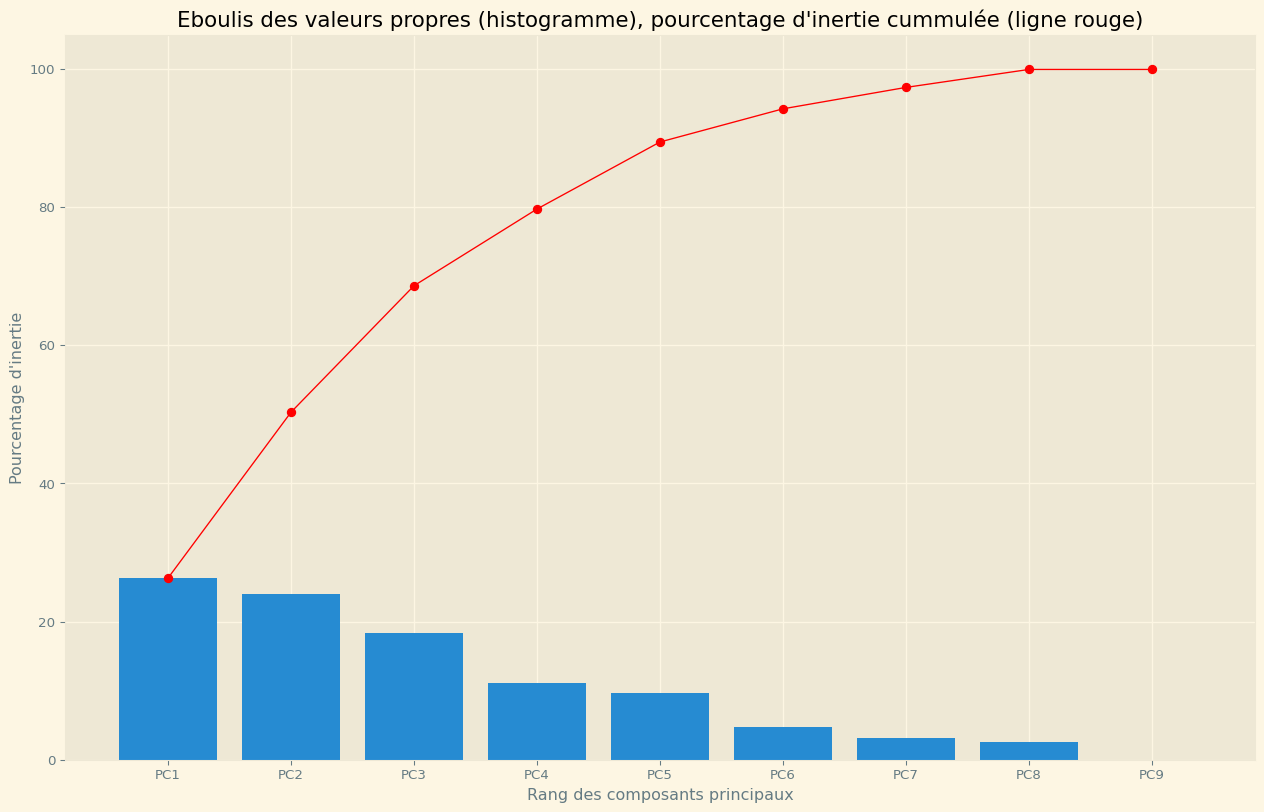

In [32]:
from scripts.pca_fn import display_circles

columns_pca = [col for col in df_off.columns if col.endswith("100g")]
data_pca = df_off[columns_pca]

data_pca = data_pca.fillna(data_pca.mean())

X = data_pca.values
names = df_off.index
features = columns_pca

scaled_data = preprocessing.scale(data_pca)
pca = PCA(n_components=len(columns_pca))
pca.fit(scaled_data)
pca_data = pca.transform(scaled_data)
percentage_variation = np.round(pca.explained_variance_ratio_ * 100, decimals=1)

labels = ["PC" + str(c) for c in range (1, len(percentage_variation) + 1)]
x_bars = np.arange(1, len(percentage_variation) + 1, 1)

cummulative_percentage = np.cumsum(percentage_variation)

fig, ax1 = plt.subplots(
    ncols=1,
    nrows=1,
    figsize=(16, 10),
    dpi=96,
)

ax1.bar(x_bars, height=percentage_variation)

ax1.set_xticks(range(1, len(labels) + 1, 1))
ax1.set_xticklabels(labels)
ax1.plot(ax1.get_xticks(), cummulative_percentage, marker="o", color="r", linewidth=1)
ax1.set_xlabel("Rang des composants principaux")
ax1.set_ylabel("Pourcentage d'inertie")

plt.title("Eboulis des valeurs propres (histogramme), pourcentage d'inertie cummulée (ligne rouge)")
plt.show()



<h4>Interprétation de l'éboulis des valeurs propres</h4>

- On constate que les composants principaux PC1 -> PC4 représentent 80% de l'inertie totale. Ils sont suffisamment représentatifs pour remplacer les variables étudiées.

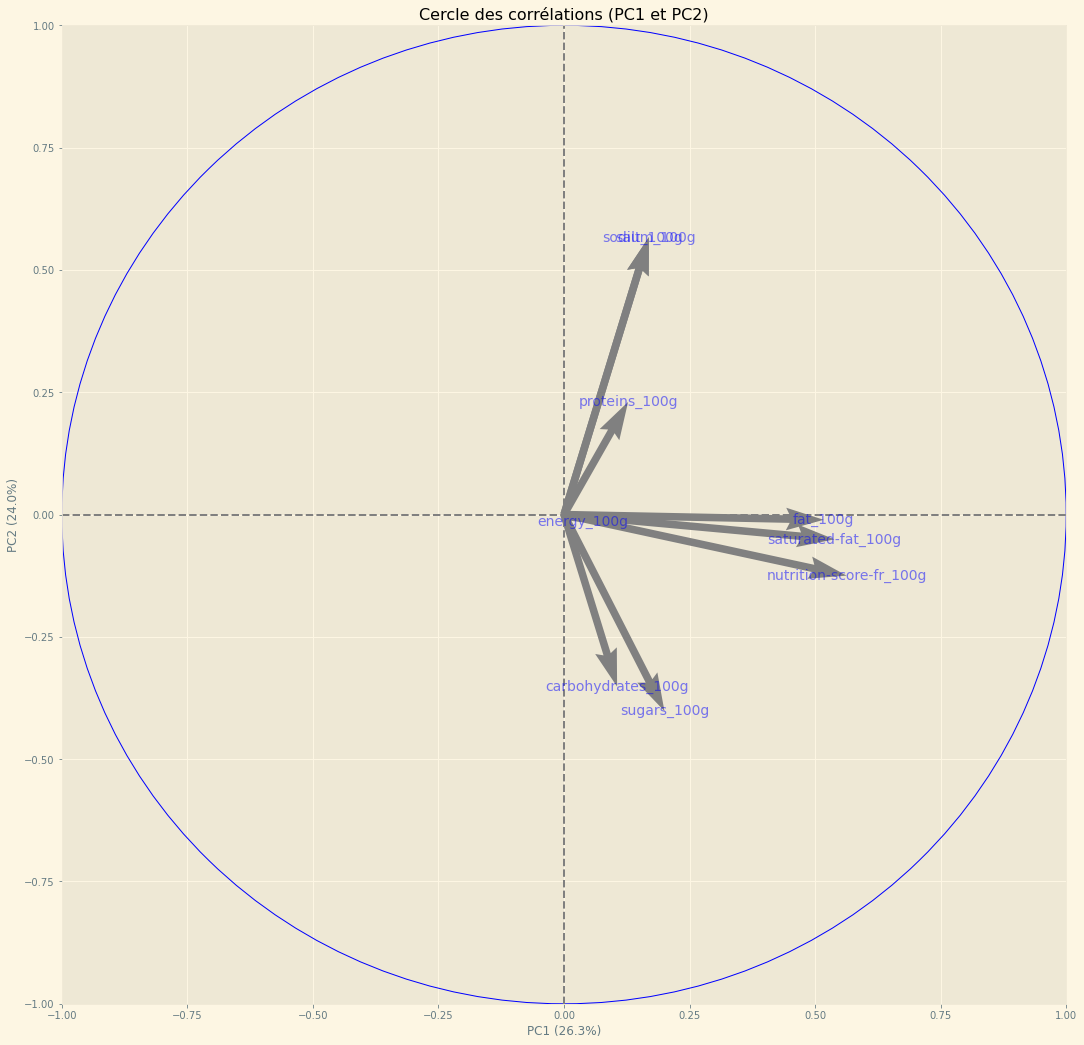

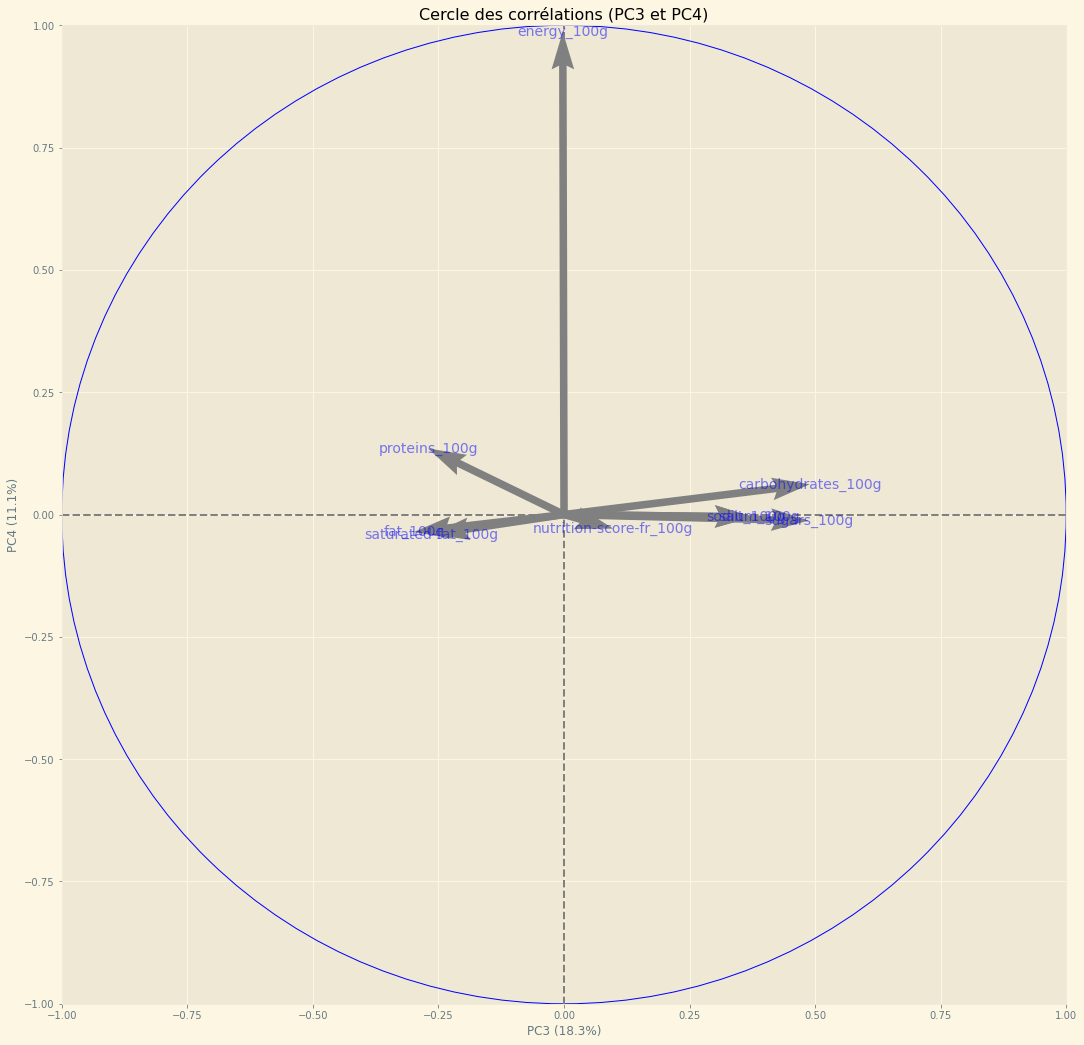

In [33]:
pcs = pca.components_
display_circles(pcs=pcs, n_comp=len(columns_pca), pca=pca, axis_ranks=[(0, 1), (2, 3)], labels=np.array(features))


<h4>Cercles de corrélation sur les 4 premiers plans factoriels</h4>

- Comme attendu, les variables suivantes sont corrélées positivement deux à deux :
  - sodium_100g / salt_100g
  - fat_100g / satured_fat_100g
  - carbohydrates_100g / sugars_100g
- On voit également que :
  - Sur les deux premiers plans factoriels : Les graisses et sucres sont positivement corrélées avec le nutriscore (plus celui ce dernier est haut, moins bonne est la note), confirmant les observations des diagrammes représentant les produits en fonction de leur nutriscore et leur teneur en graisses et sucres
  - Le sucre_100g est négativement corrélé avec le sel_100g
- <u>Clarification :</u>
  - L'axe PC1 utilise majoritairement les informations sur les graisses. Il pourrait être renommé ainsi
  - PC2 semble représenter les sucres et le sel par produits : les coefficients sont élevés pour les carbohydrates / sucres et sodium / sels
  - PC3 est très semblable a PC2
  - PC4 n'utilise quasi uniquement que l'energie pour 100g.



In [34]:
sers = {}
contrib_dict = {}

for i in range(0, len(pca.components_)):
    sers[f"PC{i + 1}"] = pd.Series(pca.components_[i], index=columns_pca)
    contrib_dict[f"PC{i + 1}"] = pd.Series(percentage_variation[i], index=["contribution"])

components_df = pd.DataFrame(sers)


In [35]:
temp = pd.DataFrame(contrib_dict)
frames = [components_df, temp]
components_df = pd.concat(frames)
components_df


,PC1,PC2,PC3,PC4,PC5,PC6,PC7,PC8,PC9
energy_100g,0.037129,-0.015026,-0.002498,0.986915,0.153688,0.026868,0.006377,-0.002350,-3.655589e-08
fat_100g,0.517026,-0.010711,-0.298858,-0.035518,0.191458,-0.367673,-0.595922,0.339160,-9.070736e-07
saturated-fat_100g,0.538535,-0.050637,-0.263624,-0.040426,0.115121,-0.147527,0.772020,0.072473,-1.444594e-06
carbohydrates_100g,0.105707,-0.351760,0.489203,0.061815,-0.336010,-0.671243,0.017952,-0.241160,-1.043087e-06
sugars_100g,0.199992,-0.401711,0.487100,-0.012332,-0.062257,0.401939,0.026917,0.628536,-3.661433e-06
proteins_100g,0.127596,0.230260,-0.270731,0.135116,-0.894806,0.102285,-0.021876,0.165921,1.307721e-06
salt_100g,0.169057,0.567178,0.375306,-0.004856,0.059545,-0.045157,0.024835,0.051463,-7.071072e-01
sodium_100g,0.169058,0.567176,0.375309,-0.004856,0.059547,-0.045159,0.024837,0.051468,7.071063e-01
nutrition-score-fr_100g,0.562737,-0.124860,0.097914,-0.028744,-0.043861,0.464400,-0.214622,-0.627431,2.589423e-06
contribution,26.300000,24.000000,18.300000,11.100000,9.700000,4.800000,3.100000,2.600000,0.000000e+00


<h4>Détails et composition des composants principaux :</h4>

- On note que PC1 -> PC4 peuvent etre potentiellement utiles pour simplifier le temps de compilation du programme. Neanmoins, cela brouillerait l'UX (l'utilisateur comprendrait et attendrait l'utilisation des valeurs pour 100g, les composants principaux, bien que simplifiant potentiellement le temps d'execution du programme, ne seraient pas facilement interpretables par l'utilisateur.
- Une ACP plus tot dans l'étude aurait été possible, mais les filtres mis en place dans le nettoyage des données rendent cette étape peu utile.
- PC6 -> PC9 apportent peu d'informations.
  
Une réduction dimensionnelle n'est pas intéressante à ce stade. Le gain en temps de calcul n'est pas significatif et l'utilisateur serait plus sucéptible d'accorder de l'importance à des variables explicites.